#简介
这个notebook展示了一个基于K线图，主要使用移动平均线和VWAP指标来捕捉趋势的策略。

---

**交易对象**：BTC-USD （15分钟级别数据）

**交易时间**：近两个月内

**交易信号判定：**

* **移动平均线部分**：

  * 当过去6个时点内最低价均低于均线，判定为均线下降趋势
  * 当过去6个时点内最高价均高于均线，判定为均线上升趋势
* **VWAP部分**

  (VWAP，成交量加权平均价格，是一个技术分析指标，用来衡量股票或其他资产在特定时间段内的平均价格，考虑了每笔交易的成交量。它用于判断当前价格相对全天平均价格的强弱)
  * 过去3个时点内最低价低于VWAP，判定为下降趋势
  * 过去3个时点内最高价高于VWAP，判定为上升趋势
* **总交易信号**
  * 移动平均和VWAP同时判定的趋势方向相同
  * 当前时间点的价格与VMAP之间相差不超过$100

**交易成本**
* 起始资金：1000,000
* 手续费：0.00025
* 交易滑点：0.0025


In [ ]:
pip install vectorbt

In [ ]:
pip install pandas_ta

In [ ]:
pip install -U kaleido

In [1]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import pandas_ta as ta
from datetime import datetime,timedelta
import yfinance as yf

In [2]:
#参数
seed=44
symbol='BTC-USD'
metric='total_return'
vbt.settings.portfolio['init_cash']=1000000
vbt.settings.portfolio['fees']=0.00025
vbt.settings.portfolio['slippage']=0.0025

In [3]:
#加载数据
data=yf.download(symbol,start='2024-08-15',end='2024-10-01',interval='15m')

[*********************100%***********************]  1 of 1 completed


In [4]:
data.shape

(4512, 6)

In [5]:
#指标
data['VWAP']=ta.vwap(data.High,data.Low,data.Close,data.Volume)
data['EMA']=ta.ema(data.Close,length=18)
data['ATR']=ta.atr(data.High,data.Low,data.Close,length=5)
data['RSI']=ta.rsi(data.Close,length=200)

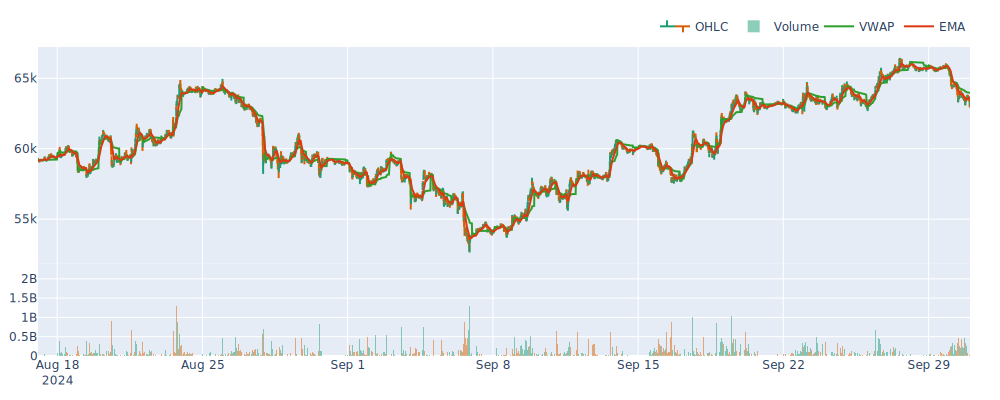

In [21]:
#区间内K线图
fig=data.vbt.ohlc().plot()
data.VWAP.vbt.plot(fig=fig)
data.EMA.vbt.plot(fig=fig)
fig.update_layout(
    width=1000,
    height=400,
)
fig.show_svg()
#fig.show() #交互式图表

In [7]:
#去除缺失值
data.dropna(inplace=True)

In [8]:
#移动平均线信号判定
emasignal=[0]*len(data)
backcandles=6
for row in range(backcandles,len(data)):
  upt=1
  dnt=1
  for i in range(row-backcandles,row+1):
    if data.High[i]>=data.EMA[i]:
      dnt=0
    if data.Low[i]<=data.EMA[i]:
      upt=0
  if upt==1 and dnt==1:
    emasignal[row]=3
  elif upt==1:
    emasignal[row]=1
  elif dnt==1:
    emasignal[row]=-1
data['EMAsignal']=emasignal


<ipython-input-8-0fb2f025fef7>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-8-0fb2f025fef7>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [9]:
print(f'得到移动平均线向上趋势信号个数为：{(data["EMAsignal"]==1).sum()}')
print(f'得到移动平均线向下趋势信号个数为：{(data["EMAsignal"]==-1).sum()}')

得到移动平均线向上趋势信号个数为：729
得到移动平均线向下趋势信号个数为：649


In [10]:
#VWAP信号判定
VWAPsignal=[0]*len(data)
backcandles=3
for row in range(backcandles,len(data)):
  upt=1
  dnt=1
  for i in range(row-backcandles,row+1):
    if data.High[i]>=data.VWAP[i]:
      dnt=0
    if data.Low[i]<=data.VWAP[i]:
      upt=0
  if upt==1 and dnt==1:
    VWAPsignal[row]=3
  elif upt==1:
    VWAPsignal[row]=1
  elif dnt==1:
    VWAPsignal[row]=-1
  else:
    VWAPsignal[row]=0
data['VWAPsignal']=VWAPsignal

<ipython-input-10-98327962885e>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-10-98327962885e>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [11]:
print(f'得到VWAP指标向上趋势信号个数为：{(data["VWAPsignal"]==1).sum()}')
print(f'得到VWAP指标向下趋势信号个数为：{(data["VWAPsignal"]==-1).sum()}')

得到VWAP指标向上趋势信号个数为：1233
得到VWAP指标向下趋势信号个数为：1436


In [12]:
#总信号判定
def total_signal(l):
  closedistance=100
  if (data.EMAsignal[l]==1
      and data.VWAPsignal[l]==1
      and min(abs(data.VWAP[l]-data.High[l]),abs(data.VWAP[l]-data.Low[l]))<=closedistance
      #and data.RSI[l]<50
      ):
    return 1
  if (data.EMAsignal[l]==-1
      and data.VWAPsignal[l]==-1
      and min(abs(data.VWAP[l]-data.High[l]),abs(data.VWAP[l]-data.Low[l]))<=closedistance
      #and 70<data.RSI[l]
      ):
    return -1


In [13]:
TotalSignal=[0]*len(data)
for row in range(0,len(data)):
  TotalSignal[row]=total_signal(row)
data['TotalSignal']=TotalSignal

<ipython-input-12-1a3a8096a5f2>:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-12-1a3a8096a5f2>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-12-1a3a8096a5f2>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-12-1a3a8096a5f2>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

In [14]:
print(f'得到总向上趋势信号个数为：{(data["TotalSignal"]==1).sum()}')
print(f'得到总向下趋势信号个数为：{(data["TotalSignal"]==-1).sum()}')

得到总向上趋势信号个数为：49
得到总向下趋势信号个数为：55


In [15]:
#基于ATR进行止损，当波动率大时，止损范围变大，当波动率小时，止损范围变小
import numba as nb

@nb.njit
def stop_loss_func(context, atr, sltpRatio=2):

    close = context.val_price_now
    signal = context.position_now

    # 初始化
    sl = close
    trailing = False

    # 计算止损
    sl_atr = 2 * atr[context.i]
    if signal == 1:
        sl = close - sl_atr
        trailing = True
    elif signal == -1:
        sl = close + sl_atr
        trailing = True
    else:
        sl = close
        trailing = False


    return sl, trailing

# 确保ATR是NumPy数组
atr = np.array(data['ATR'], dtype=np.float64)


In [16]:
#回测
entries=data['TotalSignal']==1
exits=data['TotalSignal']==-1
short_entries=data['TotalSignal']==-1
short_exits=data['TotalSignal']==1


pf=vbt.Portfolio.from_signals(data['Close'],
                              entries,
                              exits,
                              short_entries,
                              short_exits,
                              freq='15min',
                              sl_stop=0.03,
                              #sl_trail=True,#追踪止损
                              #adjust_sl_func_nb=stop_loss_func,  #基于ATR的止损函数
                              #adjust_sl_args=(atr,)


                           )

#回测结果：

下图中蓝色表示建仓，绿色表示获利平仓，红色表示亏损平仓，橙色表示交易尚未平仓。

红色的阴影表示交易期间亏损，绿色的阴影表示交易期间获利。

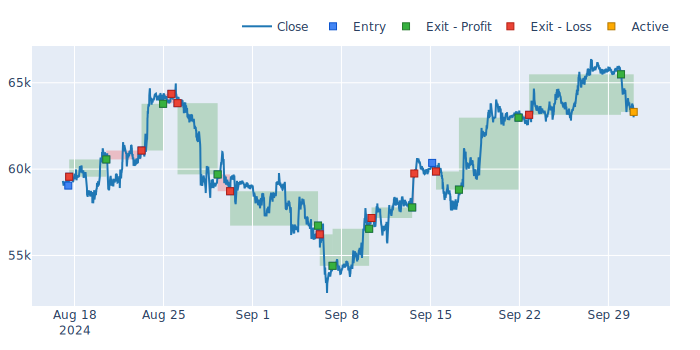

In [17]:
pf.trades.plot().show_svg()
#pf.trades.plot().show() #交互式图表

In [18]:
pf.stats()

,0
Start,2024-08-17 02:00:00
End,2024-09-30 23:45:00
Period,44 days 10:15:00
Start Value,1000000.0
End Value,1303975.698076
Total Return [%],30.39757
Benchmark Return [%],6.736065
Max Gross Exposure [%],100.0
Total Fees Paid,11304.678357
Max Drawdown [%],7.221923


In [19]:
print('交易订单详情如下：')
pf.orders.records_readable

交易订单详情如下：


,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,0,2024-08-17 12:15:00,16.931671,59046.155273,249.937516,Sell
1,1,0,2024-08-17 14:00:00,33.563411,59558.916602,499.750094,Buy
2,2,0,2024-08-20 12:00:00,33.255166,60560.582373,503.488053,Sell
3,3,0,2024-08-23 06:30:00,32.957972,61076.133779,503.236372,Buy
4,4,0,2024-08-24 23:15:00,32.660926,63781.876143,520.793786,Sell
5,5,0,2024-08-25 15:00:00,32.352952,64356.842441,520.533454,Buy
6,6,0,2024-08-26 02:30:00,32.045131,63818.109551,511.264924,Sell
7,7,0,2024-08-29 06:15:00,34.242088,59693.713691,511.009356,Buy
8,8,0,2024-08-30 05:45:00,36.437947,58719.255820,534.902289,Sell
9,9,0,2024-09-06 03:45:00,37.698133,56727.997578,534.634904,Buy


下面的三个图分别表示：
* 图1：订单交易情况
* 图2：PnL盈利和损失（绿色圆点表示获利，红色圆点表示亏损）
* 图3：累积收益（紫色线表示当前交易，深绿色线表示基准收益，即买入并一直持有）

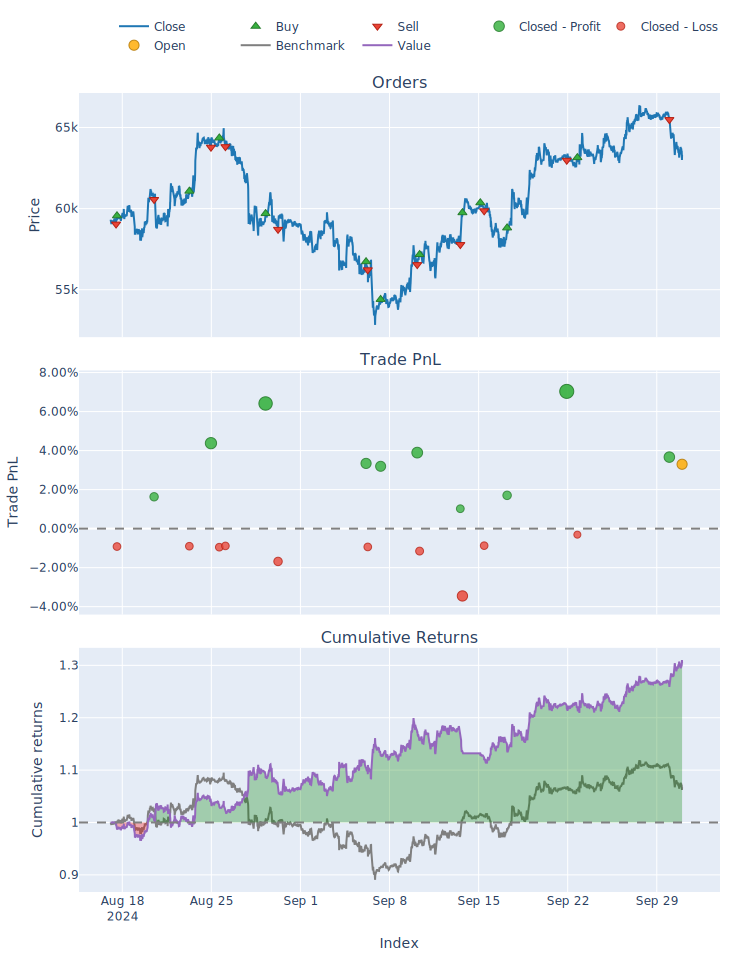

In [20]:
pf.plot().show_svg()
#pf.plot().show() #交互式图表

##总结
本策略基于K线图，主要利用移动平均线和成交量加权平均价格（VWAP）来捕捉BTC-USD的交易趋势。经过近两个月的回测，该策略展现了良好的表现和稳健的风险管理，以下是其主要优势和改进方向：
* 突出优势
  1. 从回测结果来看总回报率超过30%，显著高于基准回报率（6.74%），显示出策略的有效性。
  2. 回撤部分来看，最大回撤为7.22%，亏损最大的一笔交易为-3.45%，表现出了较强的韧性。
  3. 策略逻辑简单明了，信号生成过程透明且易于跟踪和优化。
* 改进方向
  1. 尝试引入更多的技术指标比如RSI或者布林带，增强信号的可靠性。
  2. 针对做多和做空设置不同的交易方式
  3. 对现有策略的参数进一步优化，使用网格搜索或者贝叶斯优化等方式找到最佳组合。
  4. 除了这里使用的ATR和追踪止损以外，使用更多的风险控制方式。